In [197]:
import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc, concordance_index_censored, integrated_brier_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import random

import optuna
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import brier_score
from sklearn.metrics import mean_squared_error

<p>All 5 of the imputed datasets</p>

In [169]:
train1 = pd.read_csv("../data/imputations/final_w_imps_1.csv")
train2 = pd.read_csv("../data/imputations/final_w_imps_2.csv")
train3 = pd.read_csv("../data/imputations/final_w_imps_3.csv")
train4 = pd.read_csv("../data/imputations/final_w_imps_4.csv")
train5 = pd.read_csv("../data/imputations/final_w_imps_5.csv")

train = [train1, train2, train3, train4, train5]

test1 = pd.read_csv("../data/imputations/final_w_imps_1_test.csv")
test2 = pd.read_csv("../data/imputations/final_w_imps_2_test.csv")
test3 = pd.read_csv("../data/imputations/final_w_imps_3_test.csv")
test4 = pd.read_csv("../data/imputations/final_w_imps_4_test.csv")
test5 = pd.read_csv("../data/imputations/final_w_imps_5_test.csv")

test = [test1, test2, test3, test4, test5]

<p>Removing the Pseudo-observation columns</p>

In [170]:
for idx in range(len(train)):
    train[idx] = train[idx].loc[:, ~train[idx].columns.str.startswith("PO_")]

for idx in range(len(test)):
    test[idx] = test[idx].loc[:, ~test[idx].columns.str.startswith("PO_")]

<p>Grouping ethnicities</p>

In [171]:
def collapse_ethnicity(val):
    val = str(val).upper()
    if "ASIAN" in val:
        return "Asian"
    elif "WHITE" in val or "MIDDLE" in val:
        return "White"
    elif "BLACK" in val:
        return "Black or African American"
    elif any(word in val for word in ["OTHER", "PATIENT", "UNABLE", "UNKNOWN"]):
        return "Unknown"
    elif "AMERICAN" in val:
        return "American Indian or Alaska Native"
    elif "HISPANIC" in val:
        return "Hispanic"
    elif "MULTI" in val:
        return "More than one race"
    else:
        return val

# Apply ethnicity collapsing to each dataframe in ds
for i in range(len(train)):
    if 'ethnicity' in train[i].columns:
        train[i]['ethnicity'] = train[i]['ethnicity'].apply(collapse_ethnicity)

for i in range(len(test)):
    if 'ethnicity' in test[i].columns:
        test[i]['ethnicity'] = test[i]['ethnicity'].apply(collapse_ethnicity)

C:\Users\qrJos\AppData\Local\Temp\ipykernel_15560\3172019743.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]['ethnicity'] = train[i]['ethnicity'].apply(collapse_ethnicity)
C:\Users\qrJos\AppData\Local\Temp\ipykernel_15560\3172019743.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]['ethnicity'] = test[i]['ethnicity'].apply(collapse_ethnicity)


<p>Splitting into X and y for each dataset</p>
<p>Combines into one dataset for onehot encoding before resplitting</p>

In [172]:
def splitXY(train_dfs, test_dfs):
    # Track lengths for re-splitting
    train_lengths = [len(df) for df in train_dfs]
    test_lengths = [len(df) for df in test_dfs]

    # Combine all into one DataFrame (with origin label)
    combined = pd.concat(train_dfs + test_dfs, ignore_index=True)

    # Clip negative times
    combined["survival_days"] = combined["survival_days"].clip(lower=0)
    combined["surv_days_w_mean_imps"] = combined["surv_days_w_mean_imps"].clip(lower=0)

    # Create binary outcome
    combined["survived_90"] = combined["survival_days"] > 90

    # Do one-hot encoding across the entire dataset
    X_all = pd.get_dummies(combined.drop(columns=["subject_id", "survival_days", "survived_90", "event", "surv_days_w_mean_imps", "delta"]))
    y_all = combined["surv_days_w_mean_imps"]
    y_event = combined["event"]

    # Rebuild structured target
    y_struct_all = Surv.from_arrays(event=y_event.astype(bool), time=y_all)

    # Re-split into original pieces
    X_train, y_train, X_test, y_test = [], [], [], []

    train_cumsum = [0] + list(pd.Series(train_lengths).cumsum())
    test_cumsum = [train_cumsum[-1]] + list((pd.Series(test_lengths).cumsum() + train_cumsum[-1]))

    # Slice train
    for i in range(len(train_dfs)):
        X_train.append(X_all.iloc[train_cumsum[i]:train_cumsum[i+1]].reset_index(drop=True))
        y_train.append(y_struct_all[train_cumsum[i]:train_cumsum[i+1]])

    # Slice test
    for i in range(len(test_dfs)):
        X_test.append(X_all.iloc[test_cumsum[i]:test_cumsum[i+1]].reset_index(drop=True))
        y_test.append(y_struct_all[test_cumsum[i]:test_cumsum[i+1]])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = splitXY(train, test)

time_buckets = [7, 30, 60, 180, 365, 730]

for i in range(len(y_train)):
    y_train[i] = pd.DataFrame(y_train[i])
    for t in time_buckets:
        # Create a new column event_t:
        # True if event occurred AND surv_days < t
        # False otherwise (including censored or event after t)
        y_train[i][f"event_{t}"] = ( (y_train[i]["event"] == 1) & (y_train[i]["time"] < t) )

for i in range(len(y_test)):
    y_test[i] = pd.DataFrame(y_test[i])
    for t in time_buckets:
        # Create a new column event_t:
        # True if event occurred AND surv_days < t
        # False otherwise (including censored or event after t)
        y_test[i][f"event_{t}"] = ( (y_test[i]["event"] == 1) & (y_test[i]["time"] < t) )

In [173]:
y_train[0]

,event,time,event_7,event_30,event_60,event_180,event_365,event_730
0,False,1460.000000,False,False,False,False,False,False
1,False,1460.000000,False,False,False,False,False,False
2,False,1460.000000,False,False,False,False,False,False
3,True,56.423611,False,False,True,True,True,True
4,False,1460.000000,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
448,False,1459.929821,False,False,False,False,False,False
449,False,1457.516090,False,False,False,False,False,False
450,False,1456.934240,False,False,False,False,False,False
451,False,1194.982723,False,False,False,False,False,False


In [198]:
def run_rsf(X_train_set, y_train_set, X_test_set, y_test_set, plot_fp=False):
    
    # BASE MODEL
    # rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=7)

    # OPTIMIZED, MODEL, BEST C-Index of 0.833079
    rsf = RandomSurvivalForest(n_estimators=266, min_samples_split=11, min_samples_leaf=11, max_features="log2")
    
    # OPTIMIZED MODEL, Best IBS of 0.074776
    #rsf = RandomSurvivalForest(n_estimators=243, min_samples_split=3, min_samples_leaf=1, max_features="sqrt")

    # Fit the model
    rsf.fit(X_train_set, y_train_set)

    # Predict survival functions
    surv_funcs = rsf.predict_survival_function(X_test_set)

    # Define evaluation time points
    time_buckets = np.array([7, 30, 60, 180, 365, 730])
    surv_probs = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    risk_scores = 1 - surv_probs  # Higher risk = lower survival

    feature_importance = permutation_importance(rsf, X_test_set, y_test_set, n_repeats=5, random_state=42, n_jobs=-1).importances_mean

    c_rsf = []
    
    print("  RSF C-index per time bucket:")
    for i, t in enumerate(time_buckets):
        c_index, _, _, _, _ = concordance_index_censored(
            y_test_set["event"], [x[1] for x in y_test_set], risk_scores[:, i]
        )
        print(f"    Day {t:4d}: C-index = {c_index:.4f}")
        c_rsf.append(c_index)
    print(f"  Mean RSF C-index: {sum(c_rsf) / len(c_rsf):4f}")

    # Full IBS over a grid
    surv_probs_grid = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    ibs = integrated_brier_score(y_train_set, y_test_set, surv_probs_grid, time_buckets)
    print(f"  RSF IBS:     {ibs:.4f}")

    # Permutation importance
    if plot_fp:
        perm_result = permutation_importance(
            rsf, X_test_set, y_test_set, n_repeats=10, random_state=42, n_jobs=-1
        )
        sorted_idx = perm_result.importances_mean.argsort()[::-1][:20]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), perm_result.importances_mean[sorted_idx][::-1], align='center')
        plt.yticks(range(len(sorted_idx)), X_test_set.columns[sorted_idx][::-1])
        plt.xlabel("Permutation Importance (Mean decrease in score)")
        plt.title("RSF Permutation Feature Importance (Top 20)")
        plt.tight_layout()
        plt.show()

    return sum(c_rsf) / len(c_rsf), ibs, c_rsf, feature_importance

def run_gb(X_train_set, y_train_set, X_test_set, y_test_set, plot_fp=False):

    # OPTIMIZED MODEL, Best C-Index of 0.828619
    gb = GradientBoostingSurvivalAnalysis(n_estimators=283, learning_rate=0.233, max_depth=1, random_state=7)

    # OPTIMIZED MODEL, Best IBS Score of 0.0741945
    #gb = GradientBoostingSurvivalAnalysis(n_estimators=281, learning_rate=0.218, max_depth=1, random_state=7)

    # Train the model
    gb.fit(X_train_set, y_train_set)

    # Predict survival functions
    surv_funcs = gb.predict_survival_function(X_test_set)

    # Define time buckets
    time_buckets = np.array([7, 30, 60, 180, 365, 730])
    surv_probs = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    risk_scores = 1 - surv_probs  # Higher risk = lower survival

    feature_importance = gb.feature_importances_
    
    c_gb = []
    print("  GB Time-dependent C-index per time bucket:")
    for i, t in enumerate(time_buckets):
        c_index, _, _, _, _ = concordance_index_ipcw(
            y_train_set, y_test_set, estimate=risk_scores[:, i], tau=t
        )
        print(f"    Day {t:4d}: C-index = {c_index:.4f}")
        c_gb.append(c_index)
    print(f"  Mean GB C-index: {np.mean(c_gb):.6f}")

    
    # IBS
    surv_probs_grid = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    ibs = integrated_brier_score(y_train_set, y_test_set, surv_probs_grid, time_buckets)
    print(f"  GB IBS:      {ibs:.4f}")

    # Feature importance
    if plot_fp:
        fi_gb = gb.feature_importances_
        top_idx = np.argsort(fi_gb)[::-1][:20]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(top_idx)), fi_gb[top_idx][::-1], align='center')
        plt.yticks(range(len(top_idx)), X_test_set.columns[top_idx][::-1])
        plt.xlabel("Feature Importance")
        plt.title("Gradient Boosting - Top 20 Feature Importances")
        plt.tight_layout()
        plt.show()

    return sum(c_gb) / len(c_gb), ibs, c_gb, feature_importance
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

def run_rf(X_train_set, y_train_set, X_test_set, y_test_set, plot_fp=False):
    time_buckets = np.array([7, 30, 60, 180, 365, 730])

    rf = RandomForestClassifier(
        n_estimators=266,
        min_samples_split=11,
        min_samples_leaf=11,
        max_features="log2",
        random_state=7
    )
    rf.fit(X_train_set, y_train_set["event"])

    y_proba = rf.predict_proba(X_test_set)[:, 1]

    auc = roc_auc_score(y_test_set["event"], y_proba)
    brier = brier_score_loss(y_test_set["event"], y_proba)

    print(f"  RF Overall AUC:         {auc:.4f}")
    print(f"  RF Brier Score:         {brier:.4f}")
    mse_buckets = []
    auc_buckets = []
    print("  RF AUC per time bucket:")
    for t in time_buckets:
        # Use entire y_proba but compare with event_t label
        auc_t = roc_auc_score(y_test_set[f"event_{t}"], y_proba)
        print(f"    Day {t:4d}: AUC = {auc_t:.4f}")
        mse = mean_squared_error(y_test_set[f"event_{t}"], y_proba)
        print(f"  RF MSE:                {mse:.4f}")
        auc_buckets.append(auc_t)
        mse_buckets.append(mse)

    feature_importance = rf.feature_importances_

    if plot_fp:
        perm_result = permutation_importance(
            rf, X_test_set, y_test_set["event"], n_repeats=10, random_state=42, n_jobs=-1
        )
        sorted_idx = perm_result.importances_mean.argsort()[::-1][:20]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), perm_result.importances_mean[sorted_idx][::-1], align='center')
        plt.yticks(range(len(sorted_idx)), X_test_set.columns[sorted_idx][::-1])
        plt.xlabel("Permutation Importance (Mean decrease in score)")
        plt.title("Random Forest Permutation Feature Importance (Top 20)")
        plt.tight_layout()
        plt.show()

    return auc, brier, auc_buckets, feature_importance, mse_buckets


def run_xgb(X_train_set, y_train_set, X_test_set, y_test_set, plot_fp=False):
    time_buckets = np.array([7, 30, 60, 180, 365, 730])

    xgb = XGBClassifier(
        n_estimators=283,
        learning_rate=0.233,
        max_depth=1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=7
    )
    xgb.fit(X_train_set, y_train_set["event"])

    y_proba = xgb.predict_proba(X_test_set)[:, 1]

    auc = roc_auc_score(y_test_set["event"], y_proba)
    brier = brier_score_loss(y_test_set["event"], y_proba)

    print(f"  XGB Overall AUC:         {auc:.4f}")
    print(f"  XGB Brier Score:         {brier:.4f}")

    auc_buckets = []
    mse_buckets = []
    print("  XGB AUC per time bucket:")
    for t in time_buckets:
        auc_t = roc_auc_score(y_test_set[f"event_{t}"], y_proba)
        print(f"    Day {t:4d}: AUC = {auc_t:.4f}")
        auc_buckets.append(auc_t)
        mse = mean_squared_error(y_test_set[f"event_{t}"], y_proba)
        print(f"  RF MSE:                {mse:.4f}")
        mse_buckets.append(mse)

    feature_importance = xgb.feature_importances_

    if plot_fp:
        perm_result = permutation_importance(
            xgb, X_test_set, y_test_set["event"], n_repeats=10, random_state=42, n_jobs=-1
        )
        sorted_idx = perm_result.importances_mean.argsort()[::-1][:20]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), perm_result.importances_mean[sorted_idx][::-1], align='center')
        plt.yticks(range(len(sorted_idx)), X_test_set.columns[sorted_idx][::-1])
        plt.xlabel("Permutation Importance (Mean decrease in score)")
        plt.title("XGBoost Permutation Feature Importance (Top 20)")
        plt.tight_layout()
        plt.show()

    return auc, brier, auc_buckets, feature_importance, mse_buckets


C:\Users\qrJos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [01:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\qrJos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [01:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\qrJos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarnin

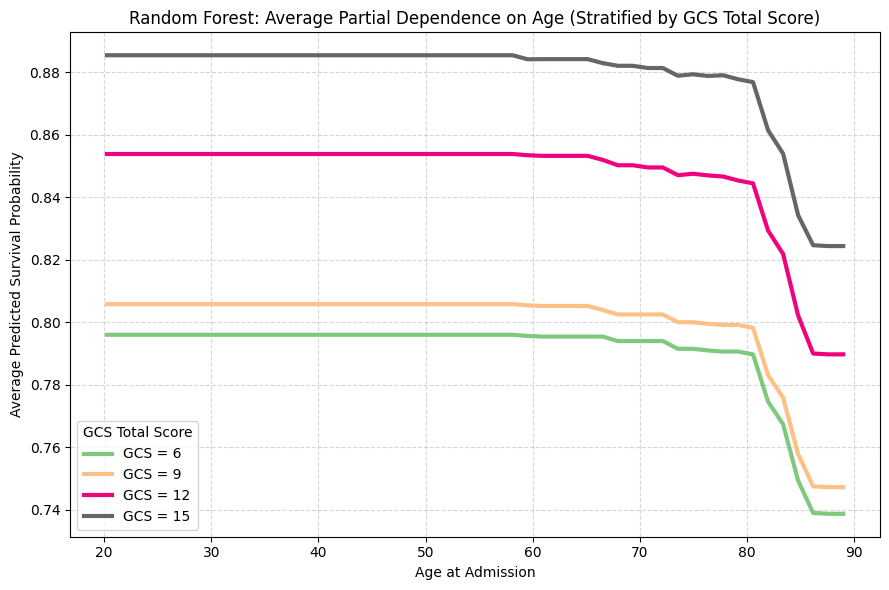

C:\Users\qrJos\AppData\Local\Temp\ipykernel_15560\3774924533.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Accent")


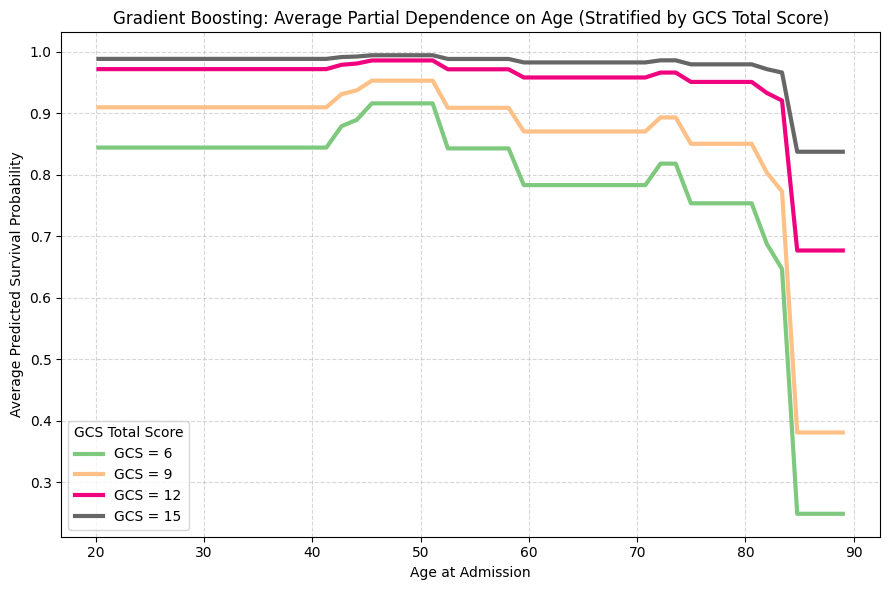

In [196]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import numpy as np

def plot_pdp_by_gcs(models, X_trains, feature_x, fixed_feature, fixed_values, model_name="Model", time_buckets=None):
    """
    Partial dependence of average predicted probability (across all time buckets) on `feature_x`
    for different fixed values of `fixed_feature`, averaged across imputations.
    
    models: list of trained classifiers (e.g., RF/XGB)
    X_trains: list of corresponding training data
    feature_x: string, variable to vary (e.g., 'age.at.admit')
    fixed_feature: string, variable to stratify by (e.g., 'gcs_total')
    fixed_values: list of fixed values for `fixed_feature` (e.g., [3, 6, 9, 12, 15])
    time_buckets: list or array of all prediction time horizons (e.g., [7, 30, 60, 180, 365, 730])
    """

    cmap = get_cmap("Accent")
    age_vals = np.linspace(
        min(X[feature_x].min() for X in X_trains),
        max(X[feature_x].max() for X in X_trains),
        50
    )

    plt.figure(figsize=(9, 6))

    for i, fixed_val in enumerate(fixed_values):
        prob_curves = []

        for model, X_ref in zip(models, X_trains):
            # Use median row as baseline input
            X_base = X_ref.median(numeric_only=True).to_frame().T
            X_base[fixed_feature] = fixed_val

            probs = []
            for age in age_vals:
                X_temp = X_base.copy()
                X_temp[feature_x] = age

                # Predict proba for all time buckets and take the average over time
                pred = model.predict_proba(X_temp)
                if isinstance(pred, list):  # For some models like XGB with multi-output
                    pred = np.array(pred)

                # Handle models returning multi-time output (e.g., shape (1, n_times))
                if pred.ndim == 2 and pred.shape[1] == len(time_buckets):
                    prob = 1 - np.mean(pred[0])  # Averaged over all time buckets
                else:
                    prob = 1 - pred[0][1]  # fallback for binary models

                probs.append(prob)

            prob_curves.append(probs)

        avg_curve = np.mean(prob_curves, axis=0)
        color = cmap(i / (len(fixed_values) - 1))
        plt.plot(age_vals, avg_curve, label=f"GCS = {fixed_val}", color=color, linewidth=3)

    plt.xlabel("Age at Admission")
    plt.ylabel("Average Predicted Survival Probability")
    plt.title(f"{model_name}: Average Partial Dependence on Age (Stratified by GCS Total Score)")
    plt.legend(title="GCS Total Score")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# Plot PDPs (e.g., at 365 days)
time_buckets = np.array([7, 30, 60, 180, 365, 730])
time_index = list(time_buckets).index(365)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define your models
xgb = XGBClassifier(
    n_estimators=283,
    learning_rate=0.233,
    max_depth=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=7
)

rf = RandomForestClassifier(
    n_estimators=266,
    min_samples_split=11,
    min_samples_leaf=11,
    max_features="log2",
    random_state=7
)

# Fit models for each imputation
rsf_models = [rf.fit(X_train[i], y_train[i]['event']) for i in range(5)]
xgb_models = [xgb.fit(X_train[i], y_train[i]['event']) for i in range(5)]

# Plot
plot_pdp_by_gcs(rsf_models, X_train, feature_x="age.at.admit", fixed_feature="gcs_total", fixed_values=[6, 9, 12, 15], model_name="Random Forest", time_buckets=time_buckets)
plot_pdp_by_gcs(xgb_models, X_train, feature_x="age.at.admit", fixed_feature="gcs_total", fixed_values=[6, 9, 12, 15], model_name="Gradient Boosting", time_buckets=time_buckets)


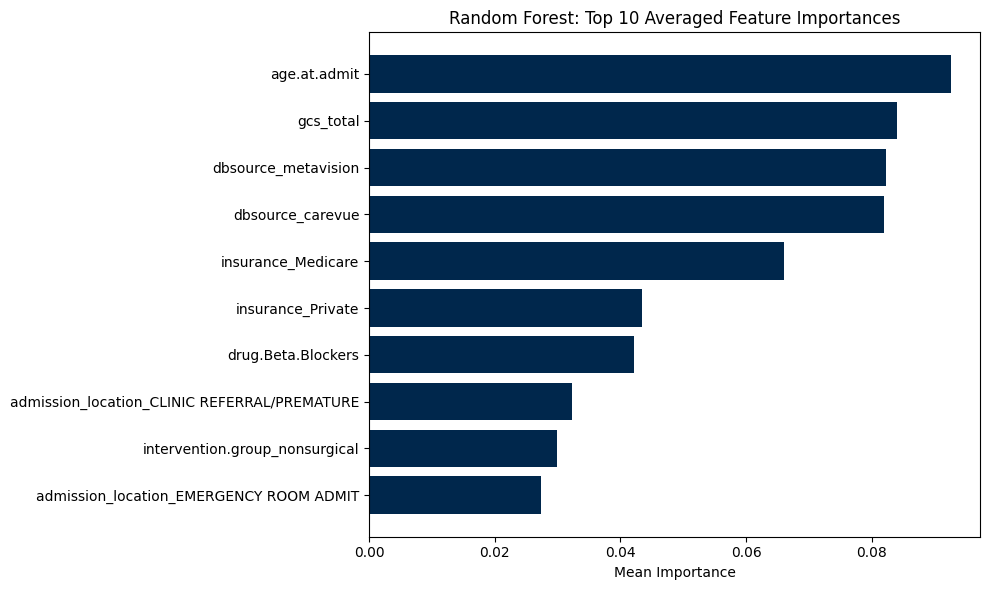

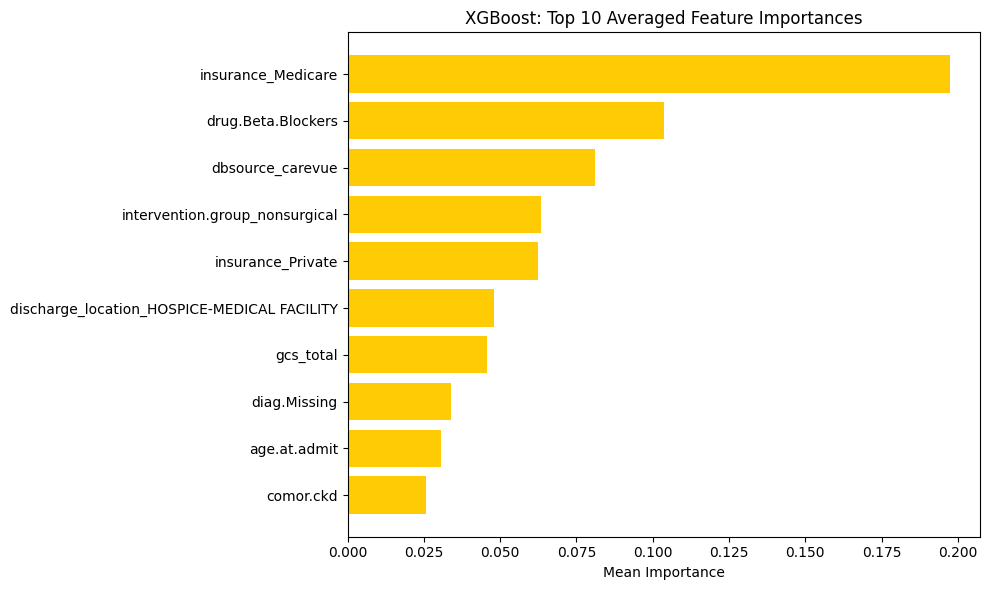

In [176]:
# Compute mean importance across imputations
avg_rsf_importance = np.mean(np.stack(rf_importances), axis=0)
avg_gb_importance = np.mean(np.stack(xgb_importances), axis=0)

# Create DataFrames for plotting
rsf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_rsf_importance
}).sort_values("Importance", ascending=False)

gb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_gb_importance
}).sort_values("Importance", ascending=False)

# RSF - Top 10 Features
plt.figure(figsize=(10, 6))
plt.barh(rsf_importance_df['Feature'][:10][::-1], rsf_importance_df['Importance'][:10][::-1], color='#00274C')
plt.title("Random Forest: Top 10 Averaged Feature Importances")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

# GB (XGBoost) - Top 10 Features
plt.figure(figsize=(10, 6))
plt.barh(gb_importance_df['Feature'][:10][::-1], gb_importance_df['Importance'][:10][::-1], color='#FFCB05')
plt.title("XGBoost: Top 10 Averaged Feature Importances")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()


Train Set 0, Test Set 3:
  RF Overall AUC:         0.8851
  RF Brier Score:         0.1141
  RF AUC per time bucket:
    Day    7: AUC = 0.6931
  RF MSE:                0.0370
    Day   30: AUC = 0.7730
  RF MSE:                0.0492
    Day   60: AUC = 0.8223
  RF MSE:                0.0623
    Day  180: AUC = 0.8406
  RF MSE:                0.0742
    Day  365: AUC = 0.8658
  RF MSE:                0.0848
    Day  730: AUC = 0.8677
  RF MSE:                0.0992



C:\Users\qrJos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [02:08:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  XGB Overall AUC:         0.8658
  XGB Brier Score:         0.1076
  XGB AUC per time bucket:
    Day    7: AUC = 0.7065
  RF MSE:                0.0523
    Day   30: AUC = 0.7251
  RF MSE:                0.0603
    Day   60: AUC = 0.7800
  RF MSE:                0.0693
    Day  180: AUC = 0.8076
  RF MSE:                0.0768
    Day  365: AUC = 0.8310
  RF MSE:                0.0835
    Day  730: AUC = 0.8560
  RF MSE:                0.0908


Train Set 1, Test Set 2:
  RF Overall AUC:         0.8813
  RF Brier Score:         0.1146
  RF AUC per time bucket:
    Day    7: AUC = 0.7174
  RF MSE:                0.0370
    Day   30: AUC = 0.7849
  RF MSE:                0.0491
    Day   60: AUC = 0.8289
  RF MSE:                0.0623
    Day  180: AUC = 0.8445
  RF MSE:                0.0742
    Day  365: AUC = 0.8660
  RF MSE:                0.0849
    Day  730: AUC = 0.8676
  RF MSE:                0.0992



C:\Users\qrJos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [02:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  XGB Overall AUC:         0.8624
  XGB Brier Score:         0.1104
  XGB AUC per time bucket:
    Day    7: AUC = 0.7467
  RF MSE:                0.0520
    Day   30: AUC = 0.7808
  RF MSE:                0.0579
    Day   60: AUC = 0.8160
  RF MSE:                0.0644
    Day  180: AUC = 0.8255
  RF MSE:                0.0750
    Day  365: AUC = 0.8424
  RF MSE:                0.0855
    Day  730: AUC = 0.8556
  RF MSE:                0.0940


Train Set 2, Test Set 4:
  RF Overall AUC:         0.8843
  RF Brier Score:         0.1152
  RF AUC per time bucket:
    Day    7: AUC = 0.7492
  RF MSE:                0.0366
    Day   30: AUC = 0.8004
  RF MSE:                0.0489
    Day   60: AUC = 0.8384
  RF MSE:                0.0622
    Day  180: AUC = 0.8473
  RF MSE:                0.0745
    Day  365: AUC = 0.8682
  RF MSE:                0.0854
    Day  730: AUC = 0.8717
  RF MSE:                0.0997



C:\Users\qrJos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [02:08:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  XGB Overall AUC:         0.8667
  XGB Brier Score:         0.1050
  XGB AUC per time bucket:
    Day    7: AUC = 0.7776
  RF MSE:                0.0560
    Day   30: AUC = 0.7783
  RF MSE:                0.0613
    Day   60: AUC = 0.8100
  RF MSE:                0.0685
    Day  180: AUC = 0.8231
  RF MSE:                0.0762
    Day  365: AUC = 0.8496
  RF MSE:                0.0800
    Day  730: AUC = 0.8660
  RF MSE:                0.0867


Train Set 3, Test Set 1:
  RF Overall AUC:         0.8812
  RF Brier Score:         0.1145
  RF AUC per time bucket:
    Day    7: AUC = 0.7258
  RF MSE:                0.0386
    Day   30: AUC = 0.7737
  RF MSE:                0.0510
    Day   60: AUC = 0.8189
  RF MSE:                0.0639
    Day  180: AUC = 0.8353
  RF MSE:                0.0756
    Day  365: AUC = 0.8581
  RF MSE:                0.0863
    Day  730: AUC = 0.8618
  RF MSE:                0.1003



C:\Users\qrJos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [02:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  XGB Overall AUC:         0.8705
  XGB Brier Score:         0.1057
  XGB AUC per time bucket:
    Day    7: AUC = 0.7784
  RF MSE:                0.0608
    Day   30: AUC = 0.7681
  RF MSE:                0.0677
    Day   60: AUC = 0.8052
  RF MSE:                0.0737
    Day  180: AUC = 0.8200
  RF MSE:                0.0817
    Day  365: AUC = 0.8387
  RF MSE:                0.0901
    Day  730: AUC = 0.8551
  RF MSE:                0.0980


Train Set 4, Test Set 0:
  RF Overall AUC:         0.8685
  RF Brier Score:         0.1161
  RF AUC per time bucket:
    Day    7: AUC = 0.6856
  RF MSE:                0.0378
    Day   30: AUC = 0.7556
  RF MSE:                0.0504
    Day   60: AUC = 0.8086
  RF MSE:                0.0636
    Day  180: AUC = 0.8296
  RF MSE:                0.0754
    Day  365: AUC = 0.8506
  RF MSE:                0.0864
    Day  730: AUC = 0.8547
  RF MSE:                0.1006



C:\Users\qrJos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [02:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  XGB Overall AUC:         0.8508
  XGB Brier Score:         0.1099
  XGB AUC per time bucket:
    Day    7: AUC = 0.6513
  RF MSE:                0.0578
    Day   30: AUC = 0.7388
  RF MSE:                0.0632
    Day   60: AUC = 0.7961
  RF MSE:                0.0687
    Day  180: AUC = 0.8160
  RF MSE:                0.0749
    Day  365: AUC = 0.8299
  RF MSE:                0.0857
    Day  730: AUC = 0.8460
  RF MSE:                0.0929




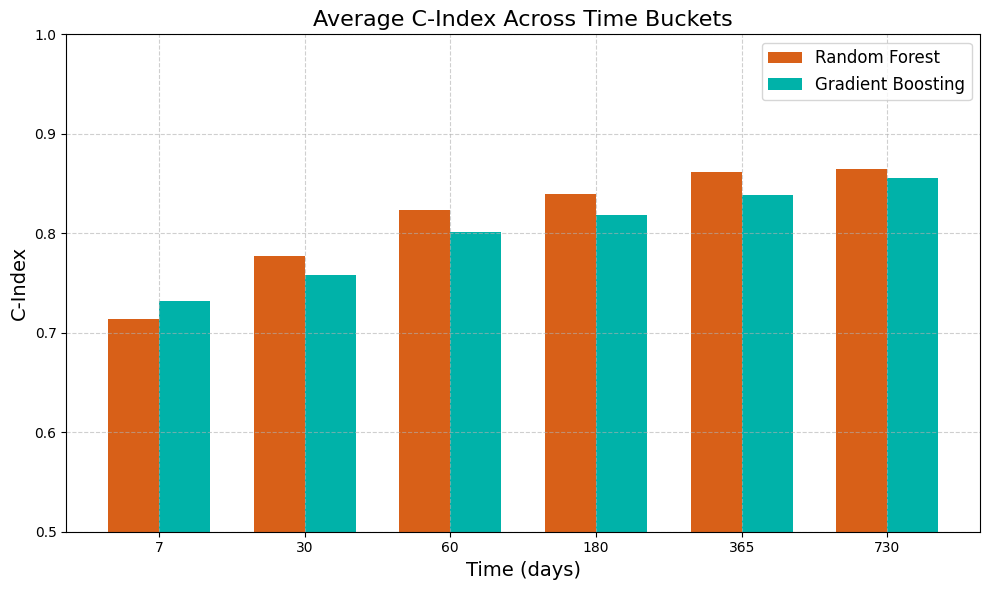

In [230]:
# Storage
import random
import numpy as np

# Storage
rf_cindex_all = []
xgb_cindex_all = []
ibs_rf = []
ibs_xgb = []
rf_cindex_buckets = []
xgb_cindex_buckets = []

time_buckets = np.array([7, 30, 60, 180, 365, 730])
indices = [0, 1, 2, 3, 4]
random.shuffle(indices)

rf_importances = []
xgb_importances = []
feature_names = X_train[0].columns

mse_rf = []
mse_xgb = []

# Loop
for i, j in enumerate(indices):
    print(f"Train Set {i}, Test Set {j}:")
    
    # RF
    c_rf_avg, ibs_rf_ind, c_rf_bucket, fi_rf, ms = run_rf(X_train[i], y_train[i], X_test[j], y_test[j], plot_fp=False)
    rf_cindex_all.append(c_rf_avg)
    ibs_rf.append(ibs_rf_ind)
    rf_cindex_buckets.append(c_rf_bucket)
    rf_importances.append(fi_rf)
    mse_rf.append(ms)
    
    print()
    
    # XGB
    c_xgb_avg, ibs_xgb_ind, c_xgb_bucket, fi_xgb, ms = run_xgb(X_train[i], y_train[i], X_test[j], y_test[j], plot_fp=False)
    xgb_cindex_all.append(c_xgb_avg)
    ibs_xgb.append(ibs_xgb_ind)
    xgb_cindex_buckets.append(c_xgb_bucket)
    xgb_importances.append(fi_xgb)
    mse_xgb.append(ms)
    
    print("\n")

# === Compute Averages ===
avg_cindex_rf = np.mean(rf_cindex_buckets, axis=0)
avg_cindex_xgb = np.mean(xgb_cindex_buckets, axis=0)

# === Plotting ===
import matplotlib.pyplot as plt


# Plotting C INDEX TOGETHER BAD
labels = [str(t) for t in time_buckets]
x = np.arange(len(time_buckets))
width = 0.35  # Width of each bar

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, avg_cindex_rf, width, label='Random Forest', color="#D86018")
bars2 = ax.bar(x + width/2, avg_cindex_xgb, width, label='Gradient Boosting', color="#00B2A9")

# Aesthetics
ax.set_title("Average C-Index Across Time Buckets", fontsize=16)
ax.set_xlabel("Time (days)", fontsize=14)
ax.set_ylabel("C-Index", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0.5, 1.0)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

#time_labels = ['7', '30', '60', '180', '365', '730']

#plt.figure(figsize=(8, 5))
#plt.bar(time_labels, avg_cindex_rf, color="#D86018", edgecolor='black')
#plt.title("Random Forest: Average C-Index by Time Bucket", fontsize=14)
#plt.xlabel("Time Bucket (Days)", fontsize=12)
#plt.ylabel("C-Index", fontsize=12)
#plt.ylim(0.5, 1.0)
#plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.tight_layout()
#plt.show()
#
## Plot XGB
#plt.figure(figsize=(8, 5))
#plt.bar(time_labels, avg_cindex_xgb, color="#00B2A9", edgecolor='black')
#plt.title("Gradient Boosting: Average C-Index by Time Bucket", fontsize=14)
#plt.xlabel("Time Bucket (Days)", fontsize=12)
#plt.ylabel("C-Index", fontsize=12)
#plt.ylim(0.5, 1.0)
#plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.tight_layout()
#plt.show()


# Bar plot: RSF - C-index per time bucket
#plt.figure(figsize=(8, 5))
#plt.bar(range(len(time_buckets)), avg_cindex_rsf, tick_label=time_buckets, color='#00274C')
#plt.ylabel("C-index")
#plt.xlabel("Time (days)")
#plt.title("RSF: Average Time-Dependent C-Index")
#plt.ylim(0, 1)
#plt.grid(axis='y', linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()
#
## Bar plot: GB - C-index per time bucket
#plt.figure(figsize=(8, 5))
#plt.bar(range(len(time_buckets)), avg_cindex_gb, tick_label=time_buckets, color='#FFCB05')
#plt.ylabel("C-index")
#plt.xlabel("Time (days)")
#plt.title("GB: Average Time-Dependent C-Index")
#plt.ylim(0, 1)
#plt.grid(axis='y', linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()
#
## Bar plot: RSF - IBS per fold
#plt.figure(figsize=(8, 5))
#plt.bar(range(len(ibs_rsf)), ibs_rsf, color='steelblue')
#plt.ylabel("IBS Score")
#plt.xlabel("Fold Index")
#plt.title("RSF: IBS per Fold")
#plt.grid(axis='y', linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()
#
## Bar plot: GB - IBS per fold
#plt.figure(figsize=(8, 5))
#plt.bar(range(len(ibs_gb)), ibs_gb, color='darkorange')
#plt.ylabel("IBS Score")
#plt.xlabel("Fold Index")
#plt.title("GB: IBS per Fold")
#plt.grid(axis='y', linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()


import pandas as pd
import numpy as np

# Stack and average
avg_rf_importance = np.mean(np.stack(rf_importances), axis=0)
avg_xgb_importance = np.mean(np.stack(xgb_importances), axis=0)


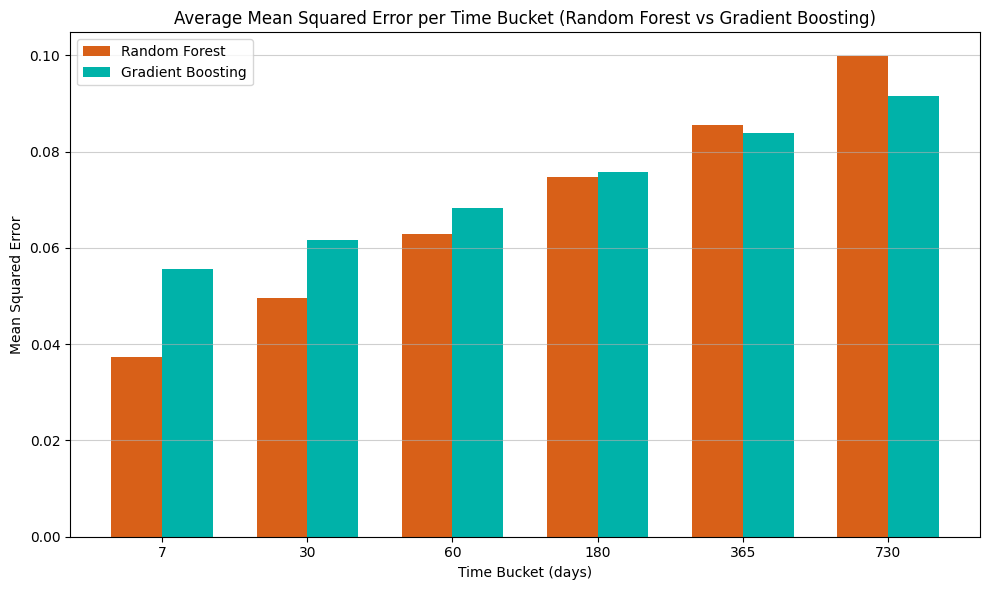

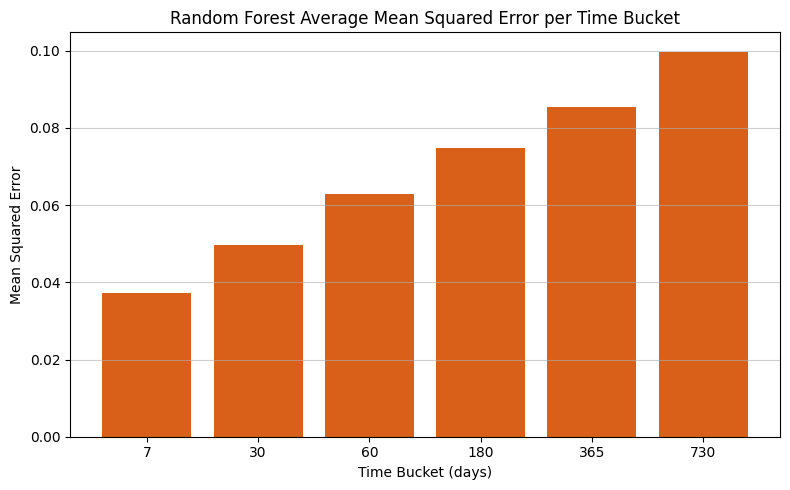

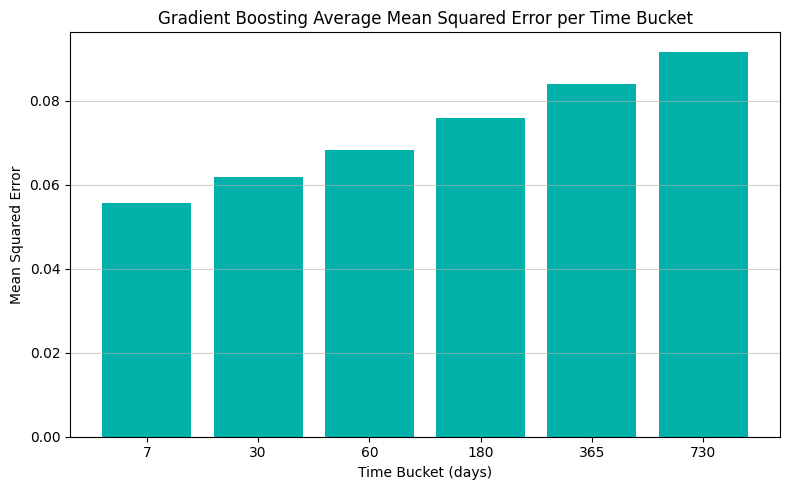

In [229]:
mse_rf_buckets = sum(np.array(mse_rf)) / 5
mse_xgb_buckets = sum(np.array(mse_xgb)) / 5

time_labels = ["7", "30", "60", "180", "365", "730"]
x = np.arange(len(time_labels))

# === 1. Combined Double Bar Chart ===
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mse_rf_buckets, width, label='Random Forest', color='#D86018')
bars2 = ax.bar(x + width/2, mse_xgb_buckets, width, label='Gradient Boosting', color='#00B2A9')

ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Time Bucket (days)')
ax.set_title('Average Mean Squared Error per Time Bucket (Random Forest vs Gradient Boosting)')
ax.set_xticks(x)
ax.set_xticklabels(time_labels)
ax.legend()
plt.grid(True, alpha=0.6, axis='y')
plt.tight_layout()
plt.show()

# === 2. RF Only Bar Chart ===
plt.figure(figsize=(8, 5))
plt.grid(True, alpha=0.6, axis='y')
plt.bar(time_labels, mse_rf_buckets, color='#D86018')
plt.ylabel('Mean Squared Error')
plt.xlabel('Time Bucket (days)')
plt.title('Random Forest Average Mean Squared Error per Time Bucket')
plt.tight_layout()
plt.show()

# === 3. XGB Only Bar Chart ===
plt.figure(figsize=(8, 5))
plt.grid(True, alpha=0.6, axis='y')
plt.bar(time_labels, mse_xgb_buckets, color='#00B2A9')
plt.ylabel('Mean Squared Error')
plt.xlabel('Time Bucket (days)')
plt.title('Gradient Boosting Average Mean Squared Error per Time Bucket')
plt.tight_layout()
plt.show()

In [73]:
feature_names

Index(['diag.H5', 'diag.I1', 'diag.S1', 'diag.H6', 'diag.M1', 'diag.Missing',
       'diag.H4', 'diag.N1', 'diag.H3', 'diag.H1',
       ...
       'ethnicity_Black or African American', 'ethnicity_Hispanic',
       'ethnicity_MORE THAN ONE RACE', 'ethnicity_Unknown', 'ethnicity_White',
       'intervention.group_craniotomy/craniectomy',
       'intervention.group_minimally_invasive_surg',
       'intervention.group_nonsurgical', 'gender_F', 'gender_M'],
      dtype='object', length=154)

In [181]:
rename_dict = {
    'gcs_total': 'GCS Total',
    'dbsource_metavision': 'Data Source: Metavision',
    'dbsource_carevue': 'Data Source: Carevue',
    'insurance_Medicare': 'Insurance: Medicare',
    'insurance_Private': 'Insurance: Private',
    'age.at.admit': 'Age at Admission',
    'drug.Beta.Blockers': 'Beta Blockers',
    'diag.Missing': 'Missing Diagnosis',
    'diag.H6': 'Diagnosis: H6',
    'intervention.group_minimally_invasive_surg': 'Minimally Invasive Surgery',
    'discharge_location_HOSPICE-MEDICAL FACILITY': 'Discharge: Hospice',
    'discharge_location_SHORT TERM HOSPITAL': 'Discharge: Short-term Hospital',
    'comor.hep_c': 'Comorbidity: Hepatitis C',
    'admission_location_CLINIC REFERRAL/PREMATURE': 'Admission Location: Clinic Referral',
    'intervention.group_nonsurgical': 'Nonsurgical Intervention',
    'admission_location_EMERGENCY ROOM ADMIT': 'Admission Location: Emergency Room',
    'comor.ckd': 'Comorbidity: Chronic Kidney Disease'
}


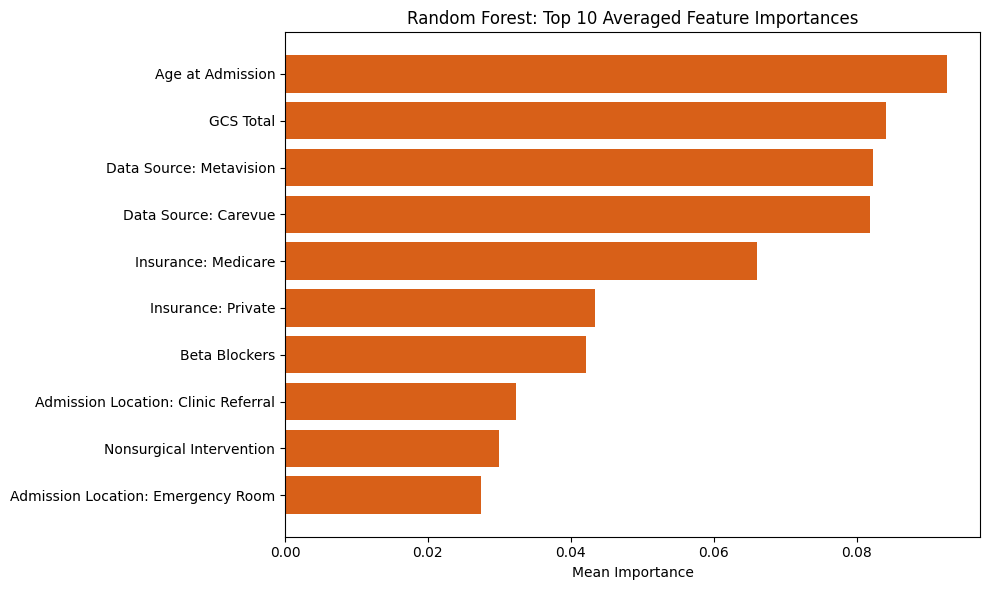

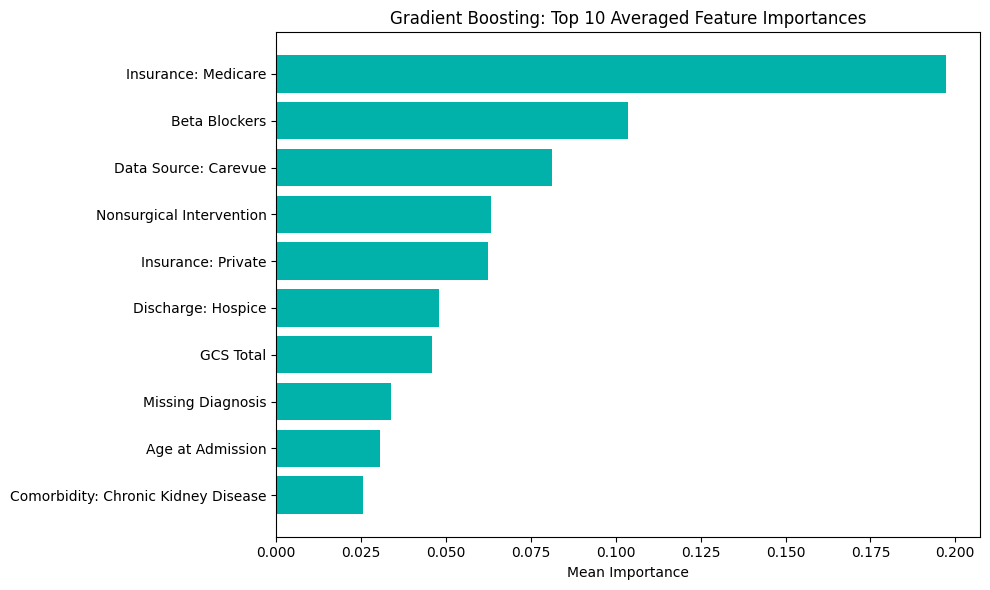

In [184]:
# Turn into DataFrames for easy plotting
rsf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_rsf_importance
}).sort_values("Importance", ascending=False)

gb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_gb_importance
}).sort_values("Importance", ascending=False)

rsf_importance_df['Feature'] = rsf_importance_df['Feature'].map(rename_dict).fillna(rsf_importance_df['Feature'])
gb_importance_df['Feature'] = gb_importance_df['Feature'].map(rename_dict).fillna(gb_importance_df['Feature'])


# RSF
plt.figure(figsize=(10, 6))
plt.barh(rsf_importance_df['Feature'][:10][::-1], rsf_importance_df['Importance'][:10][::-1], color='#D86018')
plt.title("Random Forest: Top 10 Averaged Feature Importances")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

# GB
plt.figure(figsize=(10, 6))
plt.barh(gb_importance_df['Feature'][:10][::-1], gb_importance_df['Importance'][:10][::-1], color='#00B2A9')
plt.title("Gradient Boosting: Top 10 Averaged Feature Importances")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

RSF C Index:
    7 Day: 

In [158]:
import optuna
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

def rsf_objective_cindex(trial):
    # Sample hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=7,
    )
    
    c_rsf = []

    indices = [0, 1, 2, 3, 4]
    random.shuffle(indices)
    for i, j in enumerate(indices):
        rsf.fit(X_train[i], y_train[i])
        risk_scores = rsf.predict(X_test[j])
    
        c_index, *_ = concordance_index_censored(
            y_test[j]["event"], [x[1] for x in y_test[j]], risk_scores
        )
        c_rsf.append(c_index)
    return sum(c_rsf) / len(c_rsf)  # Maximize C-index

def gb_objective_cindex(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)

    gb = GradientBoostingSurvivalAnalysis(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=7,
    )

    c_gb = []

    indices = [0, 1, 2, 3, 4]
    random.shuffle(indices)
    for i, j in enumerate(indices):
        gb.fit(X_train[i], y_train[i])
        risk_scores = gb.predict(X_test[j])
    
        c_index, *_ = concordance_index_censored(
            y_test[j]["event"], [x[1] for x in y_test[j]], risk_scores
        )
        c_gb.append(c_index)
    return sum(c_gb) / len(c_gb)

def rsf_objective_ibs(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=7,
    )

    ibs_rsf = []

    indices = [0, 1, 2, 3, 4]
    random.shuffle(indices)
    for i, j in enumerate(indices):
        rsf.fit(X_train[i], y_train[i])
    
        surv_funcs = rsf.predict_survival_function(X_test[j])
    
        # Define evaluation times (as you do)
        time_buckets = np.array([7, 30, 60, 180, 365, 730])
    
        # Convert survival functions to probability matrix (n_samples, n_times)
        surv_probs_grid = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    
        # Compute IBS
        ibs = integrated_brier_score(y_train[i], y_test[j], surv_probs_grid, time_buckets)

        ibs_rsf.append(ibs)
        
    return sum(ibs_rsf) / len(ibs_rsf)  # Minimize this score

def gb_objective_ibs(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)

    gb = GradientBoostingSurvivalAnalysis(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=7,
    )

    ibs_gb = []

    indices = [0, 1, 2, 3, 4]
    random.shuffle(indices)
    for i, j in enumerate(indices):
        gb.fit(X_train[i], y_train[i])
    
        surv_funcs = gb.predict_survival_function(X_test[j])
        
        time_buckets = np.array([7, 30, 60, 180, 365, 730])
    
        # Convert survival functions to probability matrix (n_samples, n_times)
        surv_probs_grid = np.row_stack([fn(time_buckets) for fn in surv_funcs])
    
        # Compute IBS
        ibs = integrated_brier_score(y_train[i], y_test[j], surv_probs_grid, time_buckets)

        ibs_gb.append(ibs)
        
    return sum(ibs_gb) / len(ibs_gb)  # Minimize IBS


In [195]:
study = optuna.create_study(direction="maximize")
study.optimize(rsf_objective_cindex, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-15 14:52:18,003] A new study created in memory with name: no-name-d3e777b7-aa6d-445c-84fb-4300d6a1e0fc
[I 2025-07-15 14:52:20,369] Trial 0 finished with value: 0.8019613000681328 and parameters: {'n_estimators': 131, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8019613000681328.
[I 2025-07-15 14:52:23,393] Trial 1 finished with value: 0.8294771192068431 and parameters: {'n_estimators': 222, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8294771192068431.
[I 2025-07-15 14:52:26,093] Trial 2 finished with value: 0.8276815124123436 and parameters: {'n_estimators': 215, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8294771192068431.
[I 2025-07-15 14:52:26,951] Trial 3 finished with value: 0.8180203171412816 and parameters: {'n_estimators': 64, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqr

Best trial: {'n_estimators': 266, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'log2'}


In [196]:
study = optuna.create_study(direction="maximize")
study.optimize(gb_objective_cindex, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-15 14:55:00,698] A new study created in memory with name: no-name-e8da1084-56aa-4222-9d07-9ca522e471c1
[I 2025-07-15 14:55:06,254] Trial 0 finished with value: 0.7886202689104247 and parameters: {'n_estimators': 294, 'learning_rate': 0.034981738112253594, 'max_depth': 1}. Best is trial 0 with value: 0.7886202689104247.
[I 2025-07-15 14:55:13,878] Trial 1 finished with value: 0.8148435046245768 and parameters: {'n_estimators': 291, 'learning_rate': 0.07380471318530737, 'max_depth': 3}. Best is trial 1 with value: 0.8148435046245768.
[I 2025-07-15 14:55:15,917] Trial 2 finished with value: 0.8007521691406188 and parameters: {'n_estimators': 96, 'learning_rate': 0.11162854728500779, 'max_depth': 2}. Best is trial 1 with value: 0.8148435046245768.
[I 2025-07-15 14:55:17,515] Trial 3 finished with value: 0.7153567633428285 and parameters: {'n_estimators': 76, 'learning_rate': 0.04069673314232312, 'max_depth': 1}. Best is trial 1 with value: 0.8148435046245768.
[I 2025-07-15 14:55

Best trial: {'n_estimators': 283, 'learning_rate': 0.233480358658915, 'max_depth': 1}


In [197]:
study = optuna.create_study(direction="minimize")
study.optimize(rsf_objective_ibs, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-15 14:58:33,760] A new study created in memory with name: no-name-1b38d98f-308c-4da9-b696-9154b34ab9ce
[I 2025-07-15 14:58:43,152] Trial 0 finished with value: 0.08066643841867152 and parameters: {'n_estimators': 254, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 0 with value: 0.08066643841867152.
[I 2025-07-15 14:58:44,990] Trial 1 finished with value: 0.08008205497012967 and parameters: {'n_estimators': 113, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.08008205497012967.
[I 2025-07-15 14:58:46,375] Trial 2 finished with value: 0.07993625662583256 and parameters: {'n_estimators': 66, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.07993625662583256.
[I 2025-07-15 14:58:48,006] Trial 3 finished with value: 0.0809656383240471 and parameters: {'n_estimators': 86, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': '

Best trial: {'n_estimators': 243, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [198]:
study = optuna.create_study(direction="minimize")
study.optimize(gb_objective_ibs, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-15 15:02:38,275] A new study created in memory with name: no-name-b3972278-c5ca-4c7b-b8a2-6baad91aa34b
[I 2025-07-15 15:02:43,314] Trial 0 finished with value: 0.09047055044640043 and parameters: {'n_estimators': 133, 'learning_rate': 0.21727910165428174, 'max_depth': 5}. Best is trial 0 with value: 0.09047055044640043.
[I 2025-07-15 15:02:46,743] Trial 1 finished with value: 0.08572244102371596 and parameters: {'n_estimators': 95, 'learning_rate': 0.012517363035544996, 'max_depth': 4}. Best is trial 1 with value: 0.08572244102371596.
[I 2025-07-15 15:02:54,295] Trial 2 finished with value: 0.0797310333438352 and parameters: {'n_estimators': 242, 'learning_rate': 0.02849745133286238, 'max_depth': 3}. Best is trial 2 with value: 0.0797310333438352.
[I 2025-07-15 15:03:00,578] Trial 3 finished with value: 0.07464960872648409 and parameters: {'n_estimators': 282, 'learning_rate': 0.22228164164769898, 'max_depth': 1}. Best is trial 3 with value: 0.07464960872648409.
[I 2025-07-1

Best trial: {'n_estimators': 281, 'learning_rate': 0.2182476309741365, 'max_depth': 1}


<p>Best C-Index RSF: 0.833079
Best trial: {'n_estimators': 266, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'log2'}

Best IBS RSF: 0.074776
Best trial: {'n_estimators': 243, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Best C-Index GB: 0.828619
Best trial: {'n_estimators': 283, 'learning_rate': 0.233480358658915, 'max_depth': 1}

Best IBS GB: 0.0741945
Best trial: {'n_estimators': 281, 'learning_rate': 0.2182476309741365, 'max_depth': 1}</p>

Best C-Index RSF IBS:     0.0816

Best IBS RSF C-Index:

In [113]:
y_train[y_train[0]["time"] < 8]

TypeError: only integer scalar arrays can be converted to a scalar index

In [153]:
y_train[1][y_train[1]['event_7']]

,event,time,event_7,event_30,event_60,event_180,event_365,event_730
54,True,0.465278,True,True,True,True,True,True
56,True,1.451389,True,True,True,True,True,True
81,True,1.215278,True,True,True,True,True,True
99,True,2.559028,True,True,True,True,True,True
114,True,3.562500,True,True,True,True,True,True
128,True,2.293750,True,True,True,True,True,True
191,True,3.486111,True,True,True,True,True,True
212,True,4.375000,True,True,True,True,True,True
303,True,0.340278,True,True,True,True,True,True
305,True,1.378472,True,True,True,True,True,True


In [140]:
y_train[0]['event_7']

0      False
1      False
2      False
3      False
4      False
       ...  
448    False
449    False
450    False
451    False
452    False
Name: event_7, Length: 453, dtype: bool